In [1]:
from pprint import pprint

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from IPython import display

from anguilla.dominance import non_dominated_sort
from anguilla.selection import indicator_selection
from anguilla.indicators import HypervolumeIndicator

Some code to generate lines and quadratic curves and to plot the results of non-dominated sorting and hypervolume-based selection:

In [12]:
line = lambda m, b: lambda x: m*x + b
curve = lambda a, b: lambda x: a * x * x + b

def get_objective_points(domain, *fns):
    size = len(domain) * len(fns)
    points = np.empty((size, 2))
    i = 0
    for fn in fns:
        points[i:i + len(domain), 0] = domain
        points[i:i + len(domain), 1] = fn(domain)
        i += len(domain)
    return points

def debug_plot(points, cmap="Paired", target_size=5, reference=None, yscale="linear", xscale="linear",
                    verbose=False, verbose_rank_range=None, verbose_sort_fn=None):
    if target_size > len(points):
        target_size = len(points)
    indicator = HypervolumeIndicator(reference=reference)
    selected, _ = indicator_selection(indicator, points, target_size)
    ranks, max_rank = non_dominated_sort(points)
    # Compute contributions for each group of individuals with same rank
    contributions = -1.0 + np.zeros_like(ranks)
    ranks_range = np.arange(1, max_rank+1)
    for i in ranks_range:
        idx = ranks == i
        contributions[idx] = indicator.contributions(points[idx])
    # Scatter plots with ranks and selected/not selected
    not_selected = np.logical_not(selected)
    fig = plt.figure(figsize=(20, 6))
    axs = fig.subplots(1, 3, sharex=True, sharey=True)
    markers = np.repeat("P", len(points))
    markers[not_selected] = "o"
    cmap1 = plt.cm.get_cmap(cmap, max_rank)
    cmap2 = colors.ListedColormap(["red", "green"], name="selection", N=2)
    
    def handle_pick(event):
        idx = event.ind[0]
        fig.suptitle("({}, {}), {}, {}".format(points[idx, 0], points[idx, 1], ranks[idx], contributions[idx]))
        fig.tight_layout()

    for i in range(len(points)):
        color1 = cmap1(ranks[i] / (max_rank+1))
        color2 = cmap2(float(selected[i]) / 2)
        axs[0].scatter(points[i, 0], points[i, 1], color=color1, marker=markers[i])
        axs[1].scatter(points[i, 0], points[i, 1], color=color2, marker=f"${ranks[i]}$")
    cbar1 = fig.colorbar(plt.cm.ScalarMappable(colors.Normalize(1, max_rank), cmap=cmap1), ticks=ranks_range, ax=axs[0])
    cbar1.ax.set_yticklabels([f"{i} ({np.sum(ranks < i)+1}-{np.sum(ranks <= i)})" for i in ranks_range])
    cbar2 = fig.colorbar(plt.cm.ScalarMappable(colors.Normalize(0, 1), cmap=cmap2), ticks=[0.0, 1.0], ax=axs[1])
    cbar2.ax.set_yticklabels(["Not selected", "Selected"])
    # Scatter plot with hypervolume contributions
    plot3 = axs[2].scatter(points[:, 0], points[:, 1],
                           c=np.clip(contributions, 0.0, np.iinfo(int).max),
                           cmap=plt.cm.get_cmap("coolwarm"),
                           marker="o",
                           picker=1,
                          )
    cbar3 = fig.colorbar(plot3, ax=axs[2])
    # Labels and titles
    axs[0].set_xlabel("First objective")
    axs[0].set_ylabel("Second objective")
    axs[0].set_title(f"Non-dominated sorting\nRanks: $1$ to ${max_rank}$")
    axs[1].set_title(f"Hypervolume-based selection\nSelected:${target_size} / {len(points)}$")
    axs[2].set_title(f"Hypervolume contribution\nReference: {reference}")
    axs[0].set_xscale(xscale)
    axs[0].set_yscale(yscale)
    fig.suptitle("Click on third plot")
    fig.tight_layout()
    fig.canvas.mpl_connect("pick_event", handle_pick)
    if verbose:
        def sort_fn1(individual):
            point, rank, contrib, selected = individual
            return (point[0], point[1])
    
        def sort_fn2(individual):
            point, rank, contrib, selected = individual
            return (rank, point[0], point[1])
        
        def sort_fn3(individual):
            point, rank, contrib, selected = individual
            return (rank, -contrib)
        
        def filter_fn(individual):
            point, rank, contrib, selected = individual
            min_rank, max_rank = verbose_rank_range
            return min_rank <= rank <= max_rank
    
        data = list(zip(points, ranks, contributions, selected))
        if verbose_sort_fn is not None:
            if verbose_sort_fn == 1:
                data = sorted(data, key=sort_fn1)
            elif verbose_sort_fn == 2:
                data = sorted(data, key=sort_fn2)
            else:
                data = sorted(data, key=sort_fn3)
        if verbose_rank_range is not None:
            for individual in filter(filter_fn, data):
                pprint(individual)
        else:
            pprint(data)
    return fig

def old_non_dominated_sort(points: np.ndarray):
    # Old version in Python
    size = len(points)
    ranks = np.empty(size, dtype=int)

    # Set of solutions that the solution p dominates
    s = np.empty((size, size), dtype=bool)
    for i in range(size):
        # Compute strictly dominated points
        # See p. 7 of [2007:mo-cma-es]
        # See p. 2 of [2009:hypervolume-hv3d]
        # See p. 3 of [2011:hypervolume-moo]
        # Weakly dominated points
        # np.all(np.logical_not(points[i] > points), axis=1)
        # Strictly dominated points
        np.logical_and(
            np.all(np.logical_not(points[i] > points), axis=1),
            np.any(points[i] < points, axis=1),
            out=s[i],
        )
    # Domination count
    n = np.sum(s, axis=0)
    front = n == 0
    ranks[:] = np.where(front, 1, 0)
    i = 1
    while np.any(front):
        n -= np.sum(s[front], axis=0)
        i += 1
        np.logical_and(n == 0, ranks == 0, out=front)
        ranks[front] = i
    i -= 1;
    return ranks, i

We plot some lines and curves, and assign them a color according to the rank given by the non-dominated sort.

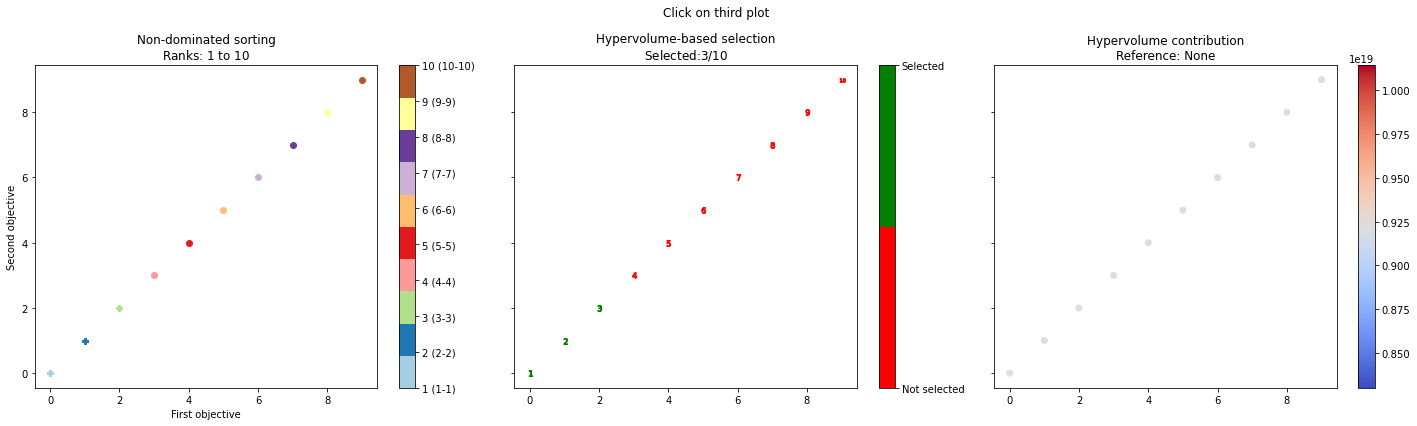

In [3]:
points = get_objective_points(np.arange(0, 10), line(1, 0))
fig = debug_plot(points, target_size=3, verbose=False)

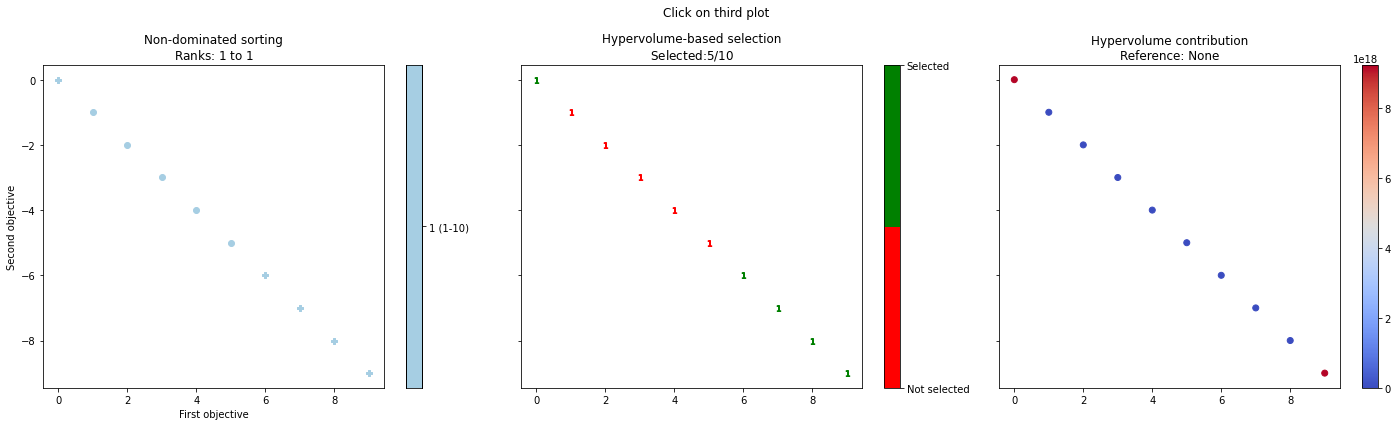

In [4]:
points = get_objective_points(np.arange(0, 10), line(-1, 0))
fig = debug_plot(points, verbose=False)

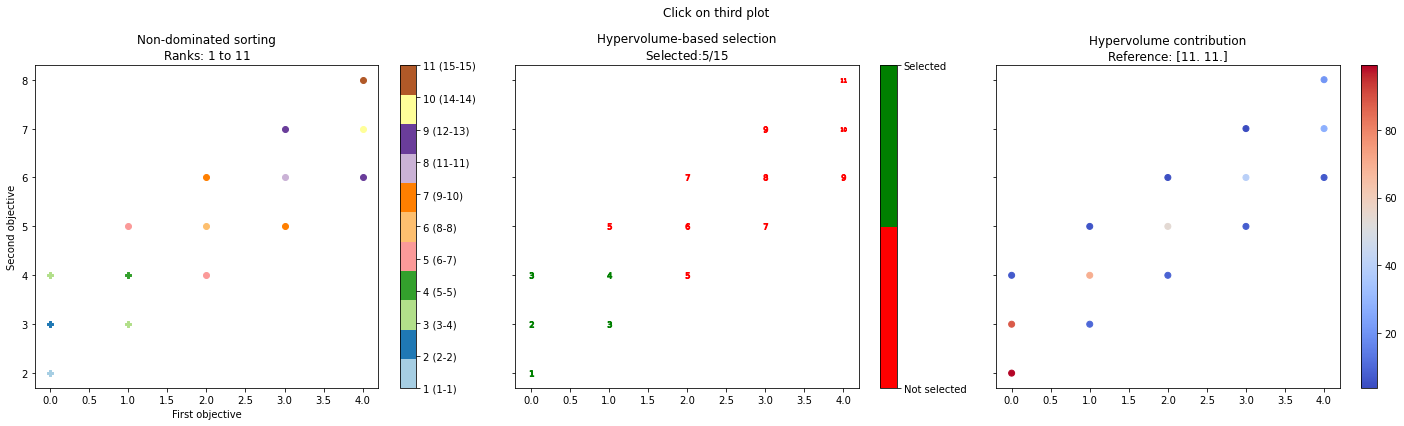

In [5]:
points = get_objective_points(np.arange(0, 5), line(1,2), line(1, 3), line(1, 4))
fig = debug_plot(points[np.argsort(points[:, 0])], reference=np.array([11., 11.]), verbose=False)

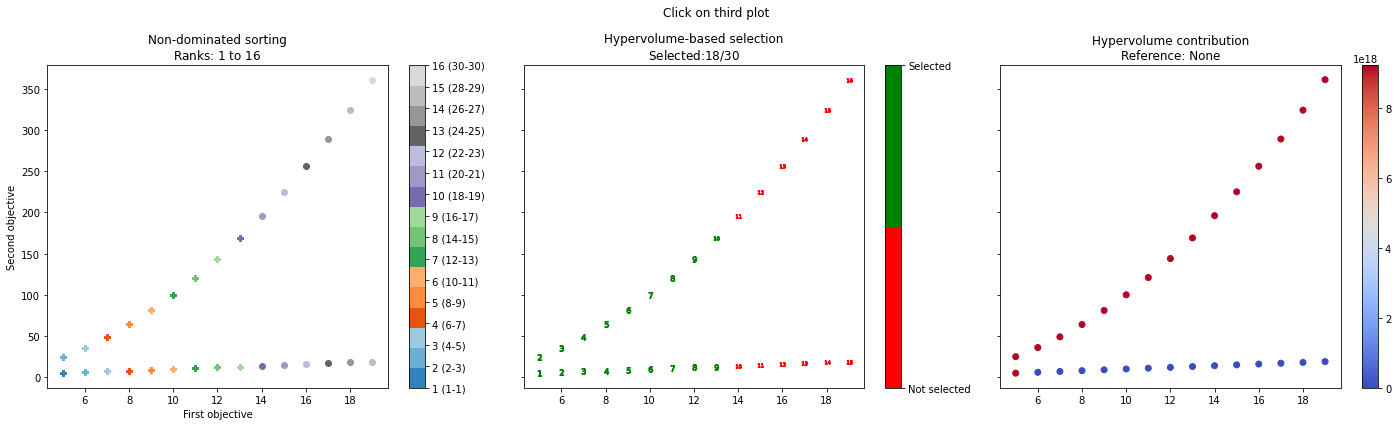

In [6]:
points = get_objective_points(np.arange(5, 20), curve(1, 0), line(1, 0))
fig = debug_plot(points,
                target_size=18,
                cmap="tab20c",
                verbose=False,
                verbose_rank_range=(1,1),
                verbose_sort_fn=1,
               )

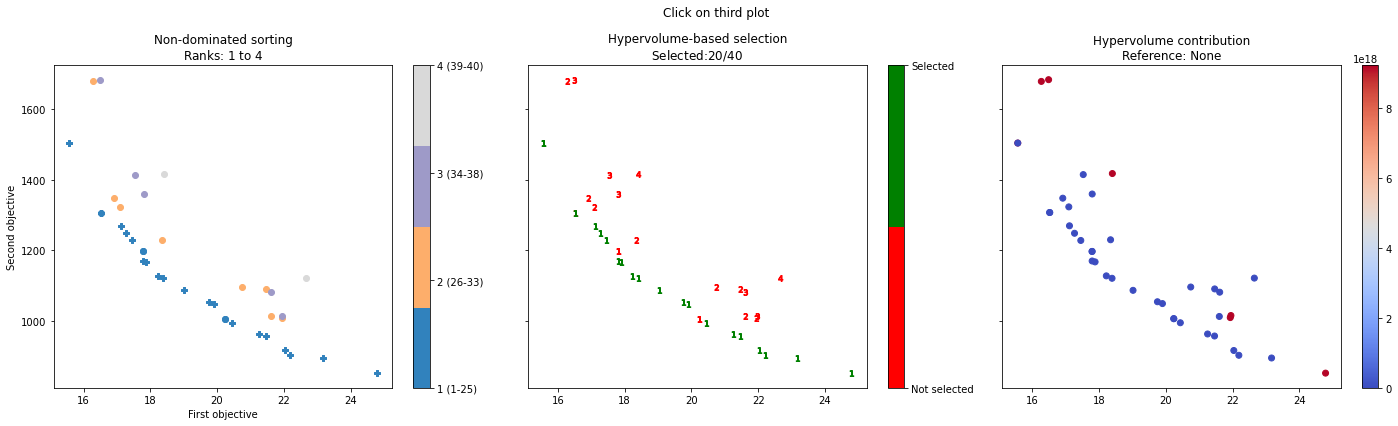

In [7]:
# Identified case with problems

points = np.array([[  15.56823491, 1503.59795947],
       [  15.56823491, 1503.59795947],
       [  16.27349729, 1678.39242822],
       [  16.49162623, 1683.30890516],
       [  16.52414146, 1306.60140036],
       [  16.52414146, 1306.60140036],
       [  16.91591725, 1347.21398507],
       [  17.09640572, 1322.5628081 ],
       [  17.11632589, 1268.89735158],
       [  17.26778876, 1247.70814561],
       [  17.4553064 , 1227.3478244 ],
       [  17.52883376, 1414.14458493],
       [  17.79339817, 1196.18126448],
       [  17.79339817, 1196.18126448],
       [  17.79505415, 1169.12824155],
       [  17.79684766, 1359.05287098],
       [  17.8834362 , 1166.52926178],
       [  18.21980483, 1126.91717879],
       [  18.34690058, 1229.27632148],
       [  18.39087587, 1120.06127845],
       [  18.40036618, 1417.11270872],
       [  19.01964622, 1085.88373692],
       [  19.75026994, 1053.51480433],
       [  19.90016463, 1048.34052953],
       [  20.23921913, 1005.54056891],
       [  20.23921913, 1005.54056891],
       [  20.43575786,  993.93328069],
       [  20.74721033, 1095.29048969],
       [  21.25195798,  962.13337454],
       [  21.46025553,  956.36793612],
       [  21.46449578, 1089.88665826],
       [  21.60317777, 1011.81383421],
       [  21.6145239 , 1080.64905706],
       [  21.93070161, 1008.60690999],
       [  21.9505931 , 1014.44768612],
       [  22.03705865,  915.27316501],
       [  22.18813765,  901.69251068],
       [  22.65153027, 1120.5932033 ],
       [  23.16741446,  894.02930456],
       [  24.78440158,  851.09782577]])

fig = debug_plot(points,
            target_size=20,
            cmap="tab20c",
            verbose=False,
            verbose_sort_fn=3,
            verbose_rank_range=(1,2),
    )

(array([-1.10171663,  0.03305722]), 3, 1.7976931348623157e+308, True)
(array([ 0.89578304, -1.29848121]), 3, 1.7976931348623157e+308, True)
(array([-0.08369619, -1.16322597]), 3, 0.11505006852784995, True)
(array([-0.98074736, -0.17315522]), 3, 0.07247527373843328, True)
(array([-0.55264732, -0.78478036]), 3, 0.06569295029123842, True)
(array([ 0.27276878, -1.23332866]), 3, 0.04367497641434495, True)
(array([-0.62928809, -0.48800582]), 3, 0.024130393407422755, True)
(array([-0.33129089, -0.84047317]), 3, 0.013789245339664696, True)
(array([-0.95826521,  1.60001909]), 4, 1.7976931348623157e+308, True)
(array([ 0.96200053, -1.18144681]), 4, 1.7976931348623157e+308, True)
(array([-0.60661154, -0.07002845]), 4, 0.23264861151572236, False)
(array([ 0.22478573, -1.10934994]), 4, 0.18015848228626155, False)
(array([-0.71331337,  0.55337847]), 4, 0.11167847535144322, False)
(array([-0.06308597, -0.58943126]), 4, 0.05542084735284394, False)
(array([ 0.10302314, -0.86497275]), 4, 0.0335506463564

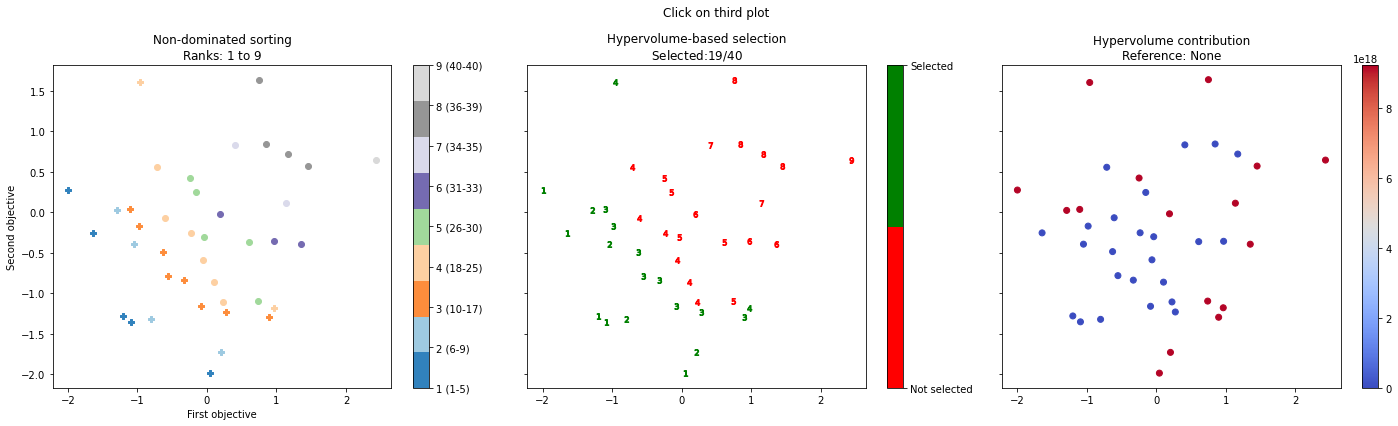

In [8]:
rng = np.random.default_rng(5)
points = rng.normal(size=(40, 2))

fig = debug_plot(points,
            target_size=19,
            cmap="tab20c",
            verbose=True,
            verbose_sort_fn=3,
            verbose_rank_range=(3,4),
    )

(array([ 0.97925082, -1.13270908]), 3, 1.7976931348623157e+308, True)
(array([-1.03074824,  0.89235204]), 3, 1.7976931348623157e+308, True)
(array([-0.69621972, -0.99299996]), 3, 1.4068568359020697, True)
(array([-0.73684022, -0.15332131]), 3, 0.021683758097476722, True)
(array([-0.76840968,  0.3804919 ]), 3, 0.016159150065138496, True)
(array([-0.27570885, -0.94660406]), 4, 1.7976931348623157e+308, True)
(array([-0.61219918, -0.88137397]), 4, 0.0, True)


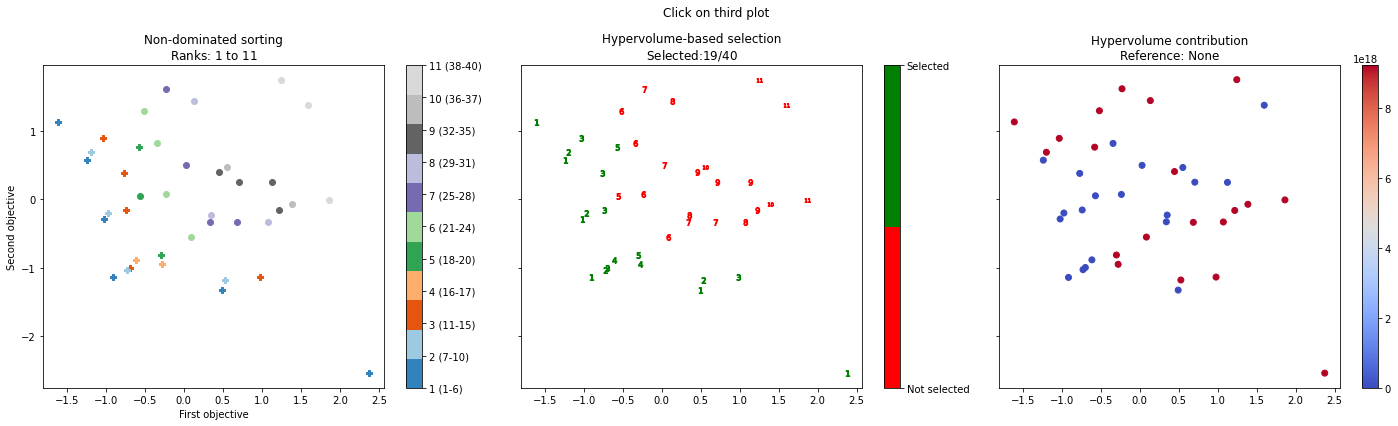

In [9]:
rng = np.random.default_rng(54)
points = rng.normal(size=(40, 2))

fig = debug_plot(points,
            target_size=19,
            cmap="tab20c",
            verbose=True,
            verbose_sort_fn=3,
            verbose_rank_range=(3,4),
    )

In [10]:
rng = np.random.default_rng()
points = rng.normal(size=(100, 2))

In [13]:
%timeit old_non_dominated_sort(points)

3.17 ms ± 99.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
%timeit non_dominated_sort(points)

124 µs ± 1.51 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
